## Martha Gavidia 

# Assignment: Fake News, Real NLP

## Objective:
Design a model to predict the truthfulness of
an article.

### Import Libraries

In [1]:
import pandas as pd
from sklearn.utils import shuffle
import string
import nltk
from nltk import sent_tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble

import numpy, string
import seaborn as sns
import matplotlib.pyplot as plt

## Data and Features
The datasets used for this assignment come from https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset. For feature engineering we'll focus on the titles of the news articles as this is the first thing a person reads and while the text of the articles may give more information, the titles are short which lowers computational cost.

#### Some features I will be exploring include:
- character count<br>
- word count <br>
- word density: character count / word count <br>
- punctuation count <br>
- title word count: number of words starting with a uppercase letter followed by all lowercase
- upper case word count: count of all words that are in all uppercase
- noun count
- pronoun count 

In [2]:
true_df = pd.read_csv("True.csv", encoding = "utf-8")
fake_df = pd.read_csv("Fake.csv", encoding = "utf-8")
pd.options.display.max_columns= 1000 # to see all columns

### True News Articles

In [3]:
print('There are',len(true_df), 'total TRUE articles.')
true_df.head()

There are 21417 total TRUE articles.


,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [4]:
true_df['char_count'] = true_df['title'].apply(len)
true_df['word_count'] = true_df['title'].apply(lambda x: len(x.split()))
true_df['word_density'] = true_df['char_count'] / (true_df['word_count']+1)
true_df['punctuation_count'] = true_df['title'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
true_df['title_word_count'] = true_df['title'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
true_df['upper_case_word_count'] = true_df['title'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))

In [5]:
true_df['title_tokenized'] = true_df['title'].fillna('').apply(lambda x: x.split())
true_df['title_pos'] = true_df['title_tokenized'].apply(nltk.tag.pos_tag)

In [6]:
def NounCounter(x):
    nouns = []
    for (word, pos) in x:
        if pos.startswith("NN"):
            nouns.append(word)
    return nouns

true_df["nouns"] = true_df["title_pos"].apply(NounCounter)
true_df["noun_count"] = true_df["nouns"].str.len()

def ProCounter(x):
    pros = []
    for (word, pos) in x:
        if pos.startswith("PRP"):
            pros.append(word)
    return pros

true_df["pros"] = true_df["title_pos"].apply(ProCounter)
true_df["pro_count"] = true_df["pros"].str.len()

### Fake News Articles

In [7]:
print('There are',len(fake_df), 'total FAKE articles.')
fake_df.head()

There are 23481 total FAKE articles.


,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [8]:
fake_df['char_count'] = fake_df['title'].apply(len)
fake_df['word_count'] = fake_df['title'].apply(lambda x: len(x.split()))
fake_df['word_density'] = fake_df['char_count'] / (fake_df['word_count']+1)
fake_df['punctuation_count'] = fake_df['title'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
fake_df['title_word_count'] = fake_df['title'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
fake_df['upper_case_word_count'] = fake_df['title'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))

In [9]:
fake_df['title_tokenized'] = fake_df['title'].fillna('').apply(lambda x: x.split())
fake_df['title_pos'] = fake_df['title_tokenized'].apply(nltk.tag.pos_tag)

In [10]:
def NounCounter(x):
    nouns = []
    for (word, pos) in x:
        if pos.startswith("NN"):
            nouns.append(word)
    return nouns

fake_df["nouns"] = fake_df["title_pos"].apply(NounCounter)
fake_df["noun_count"] = fake_df["nouns"].str.len()

def ProCounter(x):
    pros = []
    for (word, pos) in x:
        if pos.startswith("PRP"):
            pros.append(word)
    return pros

fake_df["pros"] = fake_df["title_pos"].apply(ProCounter)
fake_df["pro_count"] = fake_df["pros"].str.len()

### Create single dataframe containing all news articles

In [11]:
#create 'is_fake' column to differentiate the two once combined into single df.
fake_df['is_fake'] = 1
true_df['is_fake'] = 0

In [12]:
#combine into single df; axis set to 0 sets one df right on top of the other as opposed to side to side
df = pd.concat([true_df, fake_df], axis=0)

In [13]:
#preview the data, notice is_fake is all 0 so we need to mix our rows up
df.head()

,title,text,subject,date,char_count,word_count,word_density,punctuation_count,title_word_count,upper_case_word_count,title_tokenized,title_pos,nouns,noun_count,pros,pro_count,is_fake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",64,10,5.818182,3,3,1,"[As, U.S., budget, fight, looms,, Republicans,...","[(As, IN), (U.S., NNP), (budget, NN), (fight, ...","[U.S., budget, fight, looms,, Republicans, scr...",6,[their],1,0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",64,9,6.400000,3,3,1,"[U.S., military, to, accept, transgender, recr...","[(U.S., NNP), (military, JJ), (to, TO), (accep...","[U.S., transgender, recruits, Monday:, Pentagon]",5,[],0,0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",60,10,5.454545,6,6,1,"[Senior, U.S., Republican, senator:, 'Let, Mr....","[(Senior, JJ), (U.S., NNP), (Republican, NNP),...","[U.S., Republican, senator:, Mr., Mueller, job']",6,[his],1,0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",59,9,5.900000,2,2,2,"[FBI, Russia, probe, helped, by, Australian, d...","[(FBI, NNP), (Russia, NNP), (probe, NN), (help...","[FBI, Russia, probe, diplomat, NYT]",5,[],0,0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",69,11,5.750000,2,4,0,"[Trump, wants, Postal, Service, to, charge, 'm...","[(Trump, NN), (wants, VBZ), (Postal, NNP), (Se...","[Trump, Postal, Service, more', Amazon, shipme...",6,[],0,0


In [14]:
#here we use shuffle from sklearn.utils to shuffle the data
df = shuffle(df)
df.head()

,title,text,subject,date,char_count,word_count,word_density,punctuation_count,title_word_count,upper_case_word_count,title_tokenized,title_pos,nouns,noun_count,pros,pro_count,is_fake
14530,Brexit progress needed by early December to un...,"GOTHENBURG, Sweden (Reuters) - European Counci...",worldnews,"November 17, 2017",67,11,5.583333,2,3,0,"[Brexit, progress, needed, by, early, December...","[(Brexit, NNP), (progress, NN), (needed, VBN),...","[Brexit, progress, December, talks:, EU's, Tusk]",6,[],0,0
22774,Boiler Room EP #128 – “Free Speech… Not Withou...,Tune in to the Alternate Current Radio Network...,Middle-east,"September 29, 2017",54,11,4.500000,1,7,1,"[Boiler, Room, EP, #128, –, “Free, Speech…, No...","[(Boiler, NNP), (Room, NNP), (EP, NNP), (#128,...","[Boiler, Room, EP, #128, –, “Free, Speech…, War”]",8,[],0,1
10108,BREITBART SENIOR EDITOR SPEAKS OUT On Bannon’s...,Joel Pollack has been with Breitbart News thro...,politics,"Aug 18, 2017",90,13,6.428571,3,5,5,"[BREITBART, SENIOR, EDITOR, SPEAKS, OUT, On, B...","[(BREITBART, NNP), (SENIOR, NNP), (EDITOR, NNP...","[BREITBART, SENIOR, EDITOR, SPEAKS, OUT, Banno...",10,[],0,1
1345,Turkey urges U.S. to review visa suspension as...,ANKARA (Reuters) - Turkey urged the United Sta...,politicsNews,"October 8, 2017",66,11,5.500000,3,2,1,"[Turkey, urges, U.S., to, review, visa, suspen...","[(Turkey, NNP), (urges, VBZ), (U.S., NNP), (to...","[Turkey, U.S., suspension, stocks]",4,[],0,0
22328,CNN Fake News vs Real News: First Images of Ab...,"This week, the momentum in Syria shifted dram...",US_News,"December 9, 2016",103,18,5.421053,2,13,2,"[CNN, Fake, News, vs, Real, News:, First, Imag...","[(CNN, NNP), (Fake, NNP), (News, NNP), (vs, NN...","[CNN, Fake, News, vs, Real, News:, First, Imag...",14,[],0,1


In [15]:
for col in df.columns:
    print (col)

title
text
subject
date
char_count
word_count
word_density
punctuation_count
title_word_count
upper_case_word_count
title_tokenized
title_pos
nouns
noun_count
pros
pro_count
is_fake


### Histogram to compare select features from both datasets

Text(0.5, 0, 'Title Words in title')

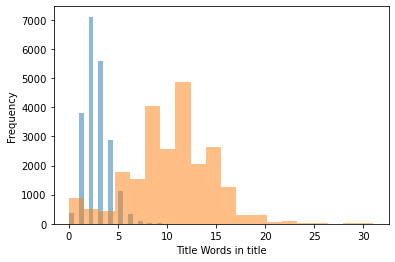

In [16]:
true_df['title_word_count'].plot.hist(bins= 20, alpha=0.5).set_xlabel("Title Words in title")
fake_df['title_word_count'].plot.hist(bins= 20, alpha=0.5).set_xlabel("Title Words in title")

Text(0.5, 0, 'Uppercase Words in title')

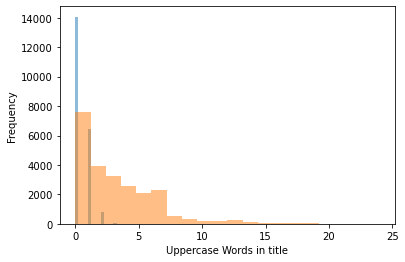

In [17]:
true_df['upper_case_word_count'].plot.hist(bins= 20, alpha=0.5).set_xlabel("Uppercase Words in title")
fake_df['upper_case_word_count'].plot.hist(bins= 20, alpha=0.5).set_xlabel("Uppercase Words in title")

Text(0.5, 0, 'Noun Count in title')

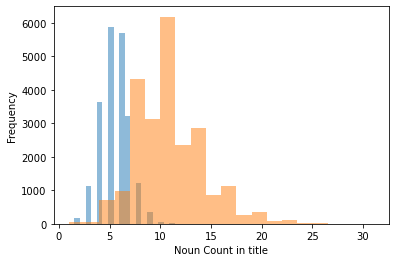

In [18]:
true_df['noun_count'].plot.hist(bins= 20, alpha=0.5).set_xlabel("Noun Count in title")
fake_df['noun_count'].plot.hist(bins= 20, alpha=0.5).set_xlabel("Noun Count in title")

### Train Title model- Naive Bayes and Logistic Regression
This model creates count vectors from the text of the titles

In [19]:
X= df['title']
y = df['is_fake']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=123,stratify=y)

In [20]:
# label encode the target variable for ML --> numeric
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(y_train)
valid_y = encoder.fit_transform(y_test)


# create a matrix. count_vect: every row represents a document from the corpus;
# every column is a term from the corpus;
# every cell represents the freq count of a particular term in particular document
 
# create a count vectorizer object for the training data
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}') # word that appears 1 or more times
count_vect.fit(df['title'])

# transform the training and testing data using count vectorizer object: doc x term
Xtrain_count =  count_vect.transform(X_train) 
Xtest_count =  count_vect.transform(X_test)

In [21]:
# Model Building
    
def train_model(classifier, feature_vector_train, y, feature_vector_test, is_neural_net=False):
# fit the training dataset on the classifier
    classifier.fit(feature_vector_train, y)

# predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_test)

    if is_neural_net:
        predictions = predictions.argmax(axis=-1)

    return metrics.accuracy_score(predictions, valid_y) 

In [22]:
# Naive Bayes on Count Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), Xtrain_count, y_train, Xtest_count)
print ("NB, Count Vectors: ", accuracy)
results_dict_model1 = {'description': 'NB, Count Vectors:', 'score': accuracy}

NB, Count Vectors:  0.9537861915367484


In [47]:
# Logistic Regression on Count Vectors
accuracy = train_model(linear_model.LogisticRegression(solver="lbfgs",multi_class="auto",max_iter=4000), Xtrain_count, y_train, Xtest_count)
print("LR, Count Vectors: ", accuracy)
results_dict_model2 = {'description': 'LR, Count Vectors:', 'score': accuracy}

LR, Count Vectors:  0.9706013363028954


### Train Title_Word_Count Model- Logistic Regression

In [38]:
X= df[['title_word_count']]
y = df['is_fake']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=123,stratify=y)

In [39]:
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)
y_pred = logistic_regression.predict(X_test)
results_dict_model3 = {'description': 'LR, Title_word_count:', 'score': metrics.accuracy_score(y_test, y_pred)}

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

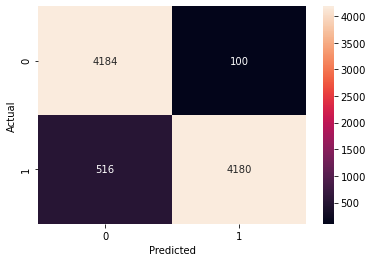

In [40]:
lr_confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(lr_confusion_matrix, annot=True, fmt="d")

In [41]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93      4284
           1       0.98      0.89      0.93      4696

    accuracy                           0.93      8980
   macro avg       0.93      0.93      0.93      8980
weighted avg       0.94      0.93      0.93      8980



### Train Title_Word_Count and Noun Count Model- Logistic Regression

In [42]:
X= df[['title_word_count','noun_count']]
y = df['is_fake']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=123,stratify=y)

In [43]:
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)
y_pred = logistic_regression.predict(X_test)
results_dict_model4 = {'description': 'LR, Title_word_count and Noun_count:', 'score': metrics.accuracy_score(y_test, y_pred)}

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

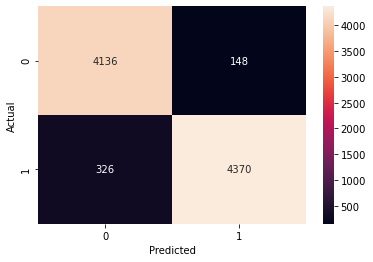

In [44]:
lr2_confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(lr2_confusion_matrix, annot=True, fmt="d")

In [45]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      4284
           1       0.97      0.93      0.95      4696

    accuracy                           0.95      8980
   macro avg       0.95      0.95      0.95      8980
weighted avg       0.95      0.95      0.95      8980



In [48]:
results_table = pd.DataFrame([results_dict_model1, results_dict_model2, results_dict_model3, results_dict_model4])
results_table

,description,score
0,"NB, Count Vectors:",0.953786
1,"LR, Count Vectors:",0.970601
2,"LR, Title_word_count:",0.931403
3,"LR, Title_word_count and Noun_count:",0.947216


The best performing model was the Logistic Regression model with count vectors, this is just the count of the words that are in the text but with some more features, such as the title word counts and the noun counts we get a similiarly high accuracy of 94%